# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [67]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
DEVICE = 'cuda:0'
NDIM = 2 # number of parameters
NBINS = 1000
SIGMA = 0.01

In [69]:
# A toy model with a diffuse and point source component

def model(z, sigma = SIGMA, w = 0.4):
    x = z + np.random.randn(2)*sigma + (np.random.rand(2)-0.5)*w
    return x

In [70]:
z0 = np.array([0.5, 0.5])
x0 = model(z0)
print(x0)

[0.41381831 0.3846334 ]


In [71]:
ds = swyft.DataStoreZarr("/home/ubuntu/volume1/z6")
ds.init(zdim = 2, xdim = (2,))

Creating empty datastore: /home/ubuntu/volume1/z6
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


In [72]:
# Instantiate network
sw = swyft.SWYFT(x0, model, zdim = 2, device = DEVICE, head = None, datastore = ds)

In [73]:
sw.advance_train_history(nsamples = 500)

Adding 494 new samples. Run simulator!


In [74]:
if sw.requires_sim():
    for i in ds.require_sim():
        z = ds.z[i]
        x = model(z)
        ds.add_sim(i, x)

In [75]:
sw.advance_net1d_history()

In [76]:
sw.train1d(max_epochs = 4)

Start training
LR iteration 0
Total epochs: 4
Validation losses: [4.5920820236206055, 3.984037160873413, 3.9361050128936768, 3.7202019691467285]
LR iteration 1
Total epochs: 4
Validation losses: [3.6301403045654297, 3.624016284942627, 3.60726261138916, 3.5963053703308105]
LR iteration 2
Total epochs: 4
Validation losses: [3.5991387367248535, 3.599167823791504, 3.5987942218780518, 3.5981805324554443]


In [77]:
sw.advance_post1d_history()

In [78]:
print(len(sw.train_history), len(sw.net1d_history), len(sw.post1d_history))

1 1 1


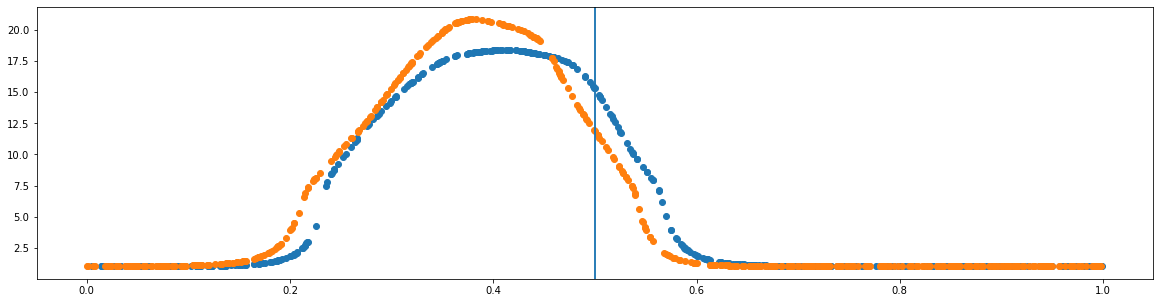

In [79]:
plt.figure(figsize=(20, 5))
for i in range(2):
    zgrid, lnLgrid = sw.posterior(i)
    plt.axvline(z0[i])
    plt.scatter(zgrid[:], np.exp(lnLgrid[:]))

In [58]:
sw.comb([[0, 1]], max_epochs = 5)

100%|██████████| 469/469 [00:00<00:00, 642.21it/s]


In [62]:
zgrid, lnLgrid = sw.posterior([0, 1])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9])
plt.xlim([0, 1])
plt.ylim([0, 1])

TypeError: cannot unpack non-iterable NoneType object

In [165]:
net = sw.net1d_history[-1]
x0 = sw.x0.cuda()
z = torch.linspace(0, 1, 10000).repeat(2, 1).T.unsqueeze(-1).cuda()
lnL = swyft.get_lnL(net, x0, z).cpu().numpy()

In [166]:
def get_intervals(x, y):
    """Get x intervals where y is above 0."""
    m = np.where(y > 0., 1., 0.)
    m = m[1:] - m[:-1]
    i0 = np.argwhere(m == 1.)[:,0]  # Upcrossings
    i1 = np.argwhere(m == -1.)[:,0]  # Downcrossings
    
    # No crossings --> return entire interval
    if len(i0) == 0 and len(i1) == 0:
        return [[x[0], x[-1]]]
    
    # One more upcrossing than downcrossing
    # --> Treat right end as downcrossing
    if len(i0) - len(i1) == 1:
        i1 = np.append(i1, -1)
  
    # One more downcrossing than upcrossing
    # --> Treat left end as upcrossing
    if len(i0) - len(i1) == -1:
        i0 = np.append(0, i0)
      
    intervals = []
    for i in range(len(i0)):
        intervals.append([x[i0[i]], x[i1[i]]])
    
    return intervals
    
get_intervals(z[:,0, 0].cpu().numpy(), lnL[:,0])

[[0.21742174, 0.5822582]]